In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock, mutation_features, methylation_pred

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
import colorcet as cc
from scipy.stats import spearmanr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

In [45]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/021423_output"
dependency_f_dir = "./dependency_files"
data_dir = "./data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
#methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'
methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/processed_methylation'
icgc_dir = "/cellar/users/zkoch/methylation_and_mutation/data/icgc"

# TCGA

### Get data

In [4]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [5]:
# read in other already computed files
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)

In [6]:
# read in train and test samples
train_samples_fn = os.path.join(dependency_f_dir, "train_samples.txt")
with open(train_samples_fn, "r") as f:
    training_samples = f.read().splitlines()
# read in train and test samples
test_samples_fn = os.path.join(dependency_f_dir,"test_samples.txt")
with open(test_samples_fn, "r") as f:
    testing_samples = f.read().splitlines()
# read in mi
mi_combined_df = pd.read_parquet(os.path.join(dependency_f_dir, 'mutual_informations', 'tcga_combinedMI_top10MI.parquet'))

In [7]:
skcm_training_samples = list(set(all_methyl_age_df_t[all_methyl_age_df_t['dataset'] == 'SKCM'].index.to_list()).intersection(set(training_samples)))
skcm_testing_samples = list(set(all_methyl_age_df_t[all_methyl_age_df_t['dataset'] == 'SKCM'].index.to_list()).intersection(set(testing_samples)))

# ICGC

### Get data

In [80]:
icgc_mut_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_mut_df.parquet")
icgc_meta_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_meta_df.parquet")
illumina_cpg_locs_df = get_data.get_illum_locs(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"))
icgc_methyl_dd = dd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/icgc/methyl_dir')
icgc_methyl_df = icgc_methyl_dd.compute()
icgc_methyl_df_t = icgc_methyl_df.T
shared_samples = set(icgc_methyl_df_t.index) & set(icgc_mut_df['sample'].unique()) & set(icgc_meta_df['sample'].unique())
icgc_methyl_df_t = icgc_methyl_df_t.loc[shared_samples]
icgc_methyl_df_t.dropna(how = 'any', axis=1, inplace=True)
icgc_mi_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/icgc_mi.parquet')
icgc_mi_df.sort_values(by='mutual_info', ascending=False, inplace=True)

In [30]:
icgc_meta_df['dataset'].value_counts()

PRAD-CA    241
PACA-AU    167
OV-AU       93
PBCA-DE     74
CLLE-ES     55
PAEN-AU     22
UTCA-FR     17
PRAD-UK      3
Name: dataset, dtype: int64

In [81]:
# rename columns 
icgc_mut_df.rename(columns={'chromosome':'chr', 'sample': 'case_submitter_id', 'chromosome_start':'start', 'MAF': 'DNA_VAF'}, inplace=True)
icgc_meta_df.rename(columns={'sample': 'case_submitter_id'}, inplace=True)
# merge with mut
icgc_mut_w_age_df = icgc_mut_df.merge(icgc_meta_df, on='case_submitter_id', how='left')
# and methyl dfs
icgc_meta_df_to_merge = icgc_meta_df[['case_submitter_id', 'age_at_index', 'dataset', 'gender']]
icgc_meta_df_to_merge.set_index('case_submitter_id', inplace=True)
# make gender column uppercase
icgc_meta_df_to_merge['gender'] = icgc_meta_df_to_merge['gender'].str.upper()
icgc_methyl_age_df_t = icgc_methyl_df_t.merge(icgc_meta_df_to_merge, left_index=True, right_index=True, how='left')

/tmp/ipykernel_1597874/2635062645.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icgc_meta_df_to_merge['gender'] = icgc_meta_df_to_merge['gender'].str.upper()


# TODO

In [ ]:
"""
1) Profile what the slowest part of creating feature matrices is and/or parallelize (either through bash jobs or python)
2) Wrap the whole thing in a 5 fold cross validation, so changing the training and testing samples each time
2) for some reason the training samples are not getting subset correctly
3) Get the ICGC data to work
"""

# Mutation features

In [117]:
mut_feat = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, out_dir = out_dir, consortium = 'TCGA', dataset = 'SKCM',
    cross_val_num = 0,
    matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/muts"
    )

In [48]:
# choose which CpGs to generate features for
skcm_mi_df = mi_combined_df['SKCM'].to_frame().rename(columns = {'SKCM':'mutual_info'})
cpg_pred_priority = mut_feat.choose_cpgs_to_train(mi_df = skcm_mi_df, bin_size=20000, sort_by=['mutual_info', 'count'])
mut_feat.create_all_feat_mats(
    cpg_ids = cpg_pred_priority.head(2)['#id'].to_list(), aggregate='Both',
    num_correl_sites=5000, num_correl_ext_sites=100, max_meqtl_sites=100,
    nearby_window_size=25000
    )
mut_feat_store_fn = mut_feat.save_mutation_features()

Finished 0 of 2
Saved mutation features to
/cellar/users/zkoch/methylation_and_mutation/output_dirs/021423_output/TCGA_SKCM_5000correl_100correlExt_100meqtl_25000nearby_Bothagg_2numCpGs_startTopCpGs_crossValNum/TCGA_SKCM_5000correl_100correlExt_100meqtl_25000nearby_Bothagg_2numCpGs_startTopCpGs_crossValNum.features.pkl


In [127]:
mut_feat_store_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/021423_output/TCGA_SKCM_5000correl_100correlExt_100meqtl_25000nearby_Bothagg_2500numCpGs_*startTopCpGs_0crossValNum/*features.pkl")
# train predictors for these cpgs
methyl_pred = methylation_pred.methylationPrediction(
    mut_feat_store_fns = mut_feat_store_fns,
    model_type = 'xgboost'
    )
methyl_pred.train_all_models()
methyl_pred.apply_all_models()
methyl_pred.save_models_and_preds()

done 0 CpGs of 10000
done 10 CpGs of 10000
done 20 CpGs of 10000
done 30 CpGs of 10000
done 40 CpGs of 10000
done 50 CpGs of 10000
done 60 CpGs of 10000
done 70 CpGs of 10000
done 80 CpGs of 10000
done 90 CpGs of 10000
done 100 CpGs of 10000
done 110 CpGs of 10000
done 120 CpGs of 10000
done 130 CpGs of 10000
done 140 CpGs of 10000
done 150 CpGs of 10000
done 160 CpGs of 10000
done 170 CpGs of 10000
done 180 CpGs of 10000
done 190 CpGs of 10000
done 200 CpGs of 10000
done 210 CpGs of 10000
done 220 CpGs of 10000
done 230 CpGs of 10000
done 240 CpGs of 10000
done 250 CpGs of 10000
done 260 CpGs of 10000
done 270 CpGs of 10000
done 280 CpGs of 10000
done 290 CpGs of 10000
done 300 CpGs of 10000
done 310 CpGs of 10000
done 320 CpGs of 10000


KeyboardInterrupt: 

# ICGC testing

In [230]:
icgc_mut_feat = mutation_features.mutationFeatures(
    all_mut_w_age_df = icgc_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = icgc_methyl_age_df_t, out_dir = out_dir, dataset = 'PRAD-CA',
    consortium = 'ICGC', train_samples = train, test_samples = test,
    matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/icgc_muts_011423"
    )

In [289]:
icgc_cpg_pred_priority = icgc_mut_feat.choose_cpgs_to_train(mi_df = icgc_mi_df, bin_size=20000, sort_by=['mutual_info', 'count'])
icgc_mut_feat.create_all_feat_mats(
    cpg_ids = icgc_cpg_pred_priority.head(10)['#id'].to_list(), aggregate='Both',
    num_correl_sites=5000, num_correl_ext_sites=100, max_meqtl_sites=100,
    nearby_window_size=25000
    )

Finished 0 of 10


In [ ]:
mut_feat_store_fns = glob.glob('/cellar/users/zkoch/methylation_and_mutation/output_dirs/020723_output/ICGC__5000correl_100correlExt_100meqtl_25000nearby_Bothagg_2500numCpGs_*/*features.pkl')
# train predictors for these cpgs
icgc_methyl_pred = methylation_pred.methylationPrediction(
    mut_feat_store_fns = mut_feat_store_fns,
    model_type = 'xgboost'
    )
icgc_methyl_pred.train_all_models()
icgc_methyl_pred.apply_all_models()
icgc_methyl_pred.save_models_and_preds()

In [102]:
train_df = icgc_methyl_age_df_t.loc[icgc_methyl_pred.train_samples, icgc_methyl_pred.mut_feat_store['cpg_ids']]
train_ages = icgc_methyl_age_df_t.loc[icgc_methyl_pred.train_samples, 'age_at_index'].dropna()
train_df = train_df.loc[train_ages.index, :]

test_df = icgc_methyl_pred.pred_df
test_ages = icgc_methyl_age_df_t.loc[icgc_methyl_pred.test_samples, 'age_at_index']

In [ ]:
model = ElasticNetCV(cv=5, random_state=0, max_iter=10000, n_jobs=-1, verbose=1)
# train the model on the training set
model.fit(train_df, train_ages)
# predict the ages on the test set
pred_ages = model.predict(test_df)

0.8288474017235258

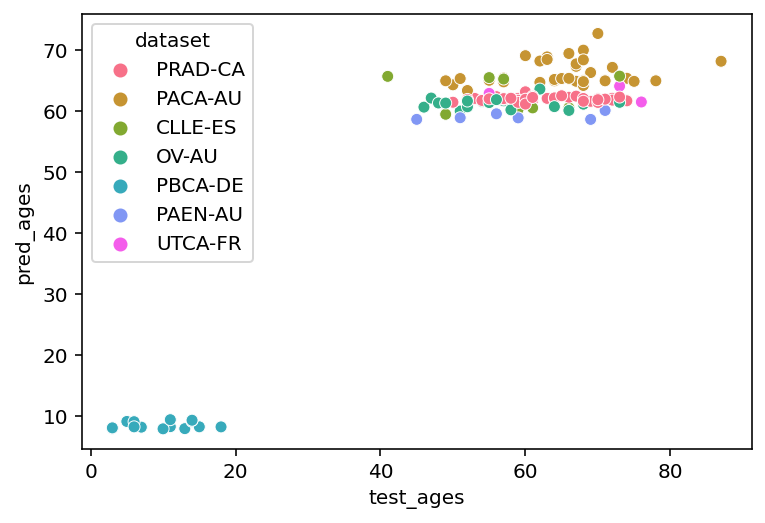

In [113]:
to_plot = pd.DataFrame({'pred_ages':pred_ages, 'test_ages':test_ages, 'dataset': icgc_methyl_age_df_t.loc[icgc_methyl_pred.test_samples, 'dataset'].to_list()})
sns.scatterplot(data=to_plot, x='test_ages', y='pred_ages', hue='dataset')
print(np.corrcoef(test_ages, pred_ages)[0][1]**2